# Autoencoders

VAEs or even just AEs are fairly complicated compared to the models we've built so far. This notebook will go through training a AE in torchbearer and introduce callbacks and their usefulness. 

## Setup 

We done the boring bit of setting up the data loading and transforming data. We've also created a validation set from the training data using the [dataset splitter](https://torchbearer.readthedocs.io/en/latest/code/main.html#torchbearer.cv_utils.DatasetValidationSplitter) provided in torchbearer. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt


import torchbearer
from torchbearer.cv_utils import DatasetValidationSplitter

BATCH_SIZE = 128

transform = transforms.Compose([transforms.ToTensor()])

# Define standard classification mnist dataset with random validation set

dataset = torchvision.datasets.MNIST('./data/mnist', train=True, download=True, transform=transform)
splitter = DatasetValidationSplitter(len(dataset), 0.1)
trainset = splitter.get_train_dataset(dataset)
valset = splitter.get_val_dataset(dataset)

traingen = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

valgen = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

# State keys
MU, LOGVAR = torchbearer.state_key('mu'), torchbearer.state_key('logvar')

## Data targets

For this problem, our targets are the input images. 
We have some options to make the dataset we have output images as targets:
- Re-write or wrap the dataset to return images
- Write a callback that replaces the target with the data
- Replace the target with data in the model forward pass

If you would like to create a callback to do this, there is a skeleton below, however any of these solutions can be implemented here. The list of preset state keys are defined [here](https://torchbearer.readthedocs.io/en/latest/_modules/torchbearer/state.html#State) at the bottom of the file until we  

In [2]:
@torchbearer.callbacks.on_sample
@torchbearer.callbacks.on_sample_validation
def replace_targets(state):
    pass

## Model

The pytorch model is a bit fiddly so its provided mostly finished below. It might be useful to have access to the mean and log-variance later on, can you add something to the model to do this? 

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, state):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        ## Perhaps add something here? 

        return self.decode(z)
    
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Visualising

For this example we make use of a callback to visualise results.

In [4]:
@torchbearer.callbacks.once_per_epoch
@torchbearer.callbacks.on_step_validation
def visualiser(state):
    data = state[torchbearer.X]
    recon_batch = state[torchbearer.Y_PRED].view(-1, 1, 28, 28)
        
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('True')
    plt.imshow(data[0].repeat(3,1,1).permute(1,2,0).cpu())
            
    plt.subplot(1,2,2)
    plt.title('Reconstruction')
    plt.imshow(recon_batch[0].repeat(3,1,1).permute(1,2,0).cpu())
    plt.show()


## VAE Loss

The vae loss is the sum of the BCE_loss (or mse_loss) and the KLD loss. The BCE is a reconstruction loss and so takes y_pred and y_true, the KLD however requires the mean and log-variance. 

Can you work out how to add the KLD to the loss? Perhaps take a look at the callback decorators ([here](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#module-torchbearer.callbacks.decorators)) which can take a function of state and create a callback from it. 

0/10(v):   2%|▏         | 1/47 [00:00<00:00, 195.84it/s]

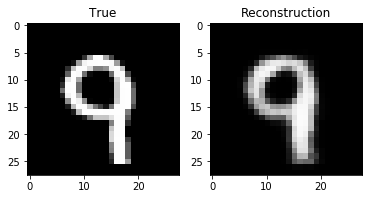

1/10(v):   2%|▏         | 1/47 [00:00<00:03, 13.76it/s]

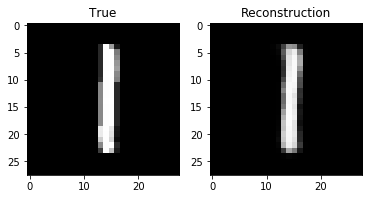

2/10(v):   2%|▏         | 1/47 [00:00<00:00, 82.65it/s]

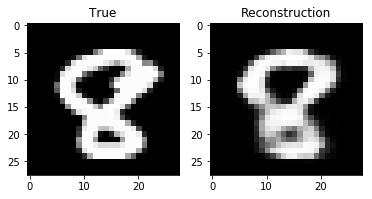

3/10(v):   2%|▏         | 1/47 [00:00<00:00, 76.94it/s]

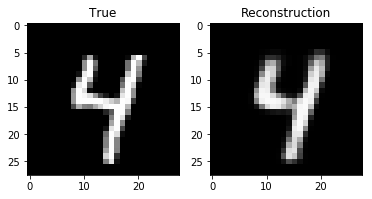

4/10(v):   2%|▏         | 1/47 [00:00<00:02, 16.13it/s]

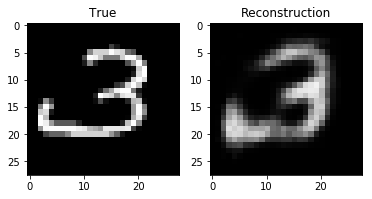

5/10(v):   2%|▏         | 1/47 [00:00<00:00, 137.12it/s]

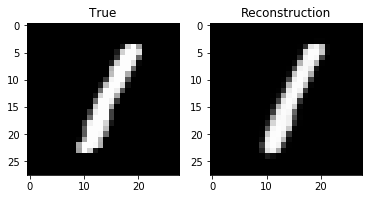

6/10(v):   2%|▏         | 1/47 [00:00<00:00, 51.07it/s]

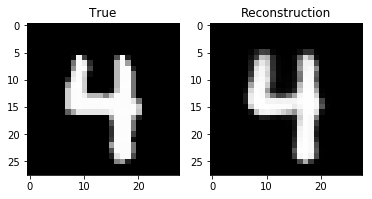

7/10(v):   2%|▏         | 1/47 [00:00<00:00, 48.98it/s]

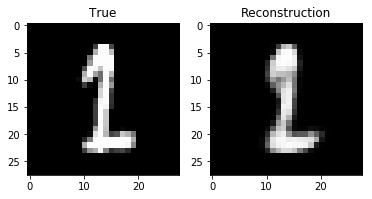

8/10(v):   2%|▏         | 1/47 [00:00<00:00, 177.19it/s]

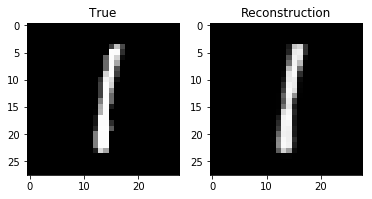

9/10(v):   2%|▏         | 1/47 [00:00<00:02, 21.30it/s]

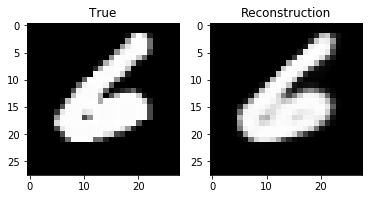

9/10(v): 100%|██████████| 47/47 [00:00<00:00, 115.40it/s, val_loss=8.77e+03, val_loss_std=370]


[((422, 47),
  {'running_loss': 11934.04431640625,
   'loss': 17589.66940351007,
   'loss_std': 7765.111861290196,
   'val_loss': 11793.19448138298,
   'val_loss_std': 485.0144205153085}),
 ((422, 47),
  {'running_loss': 10263.5635546875,
   'loss': 10785.278007905064,
   'loss_std': 527.6597875914655,
   'val_loss': 10147.089345079787,
   'val_loss_std': 323.1730212930316}),
 ((422, 47),
  {'running_loss': 9713.2602734375,
   'loss': 9895.325977488152,
   'loss_std': 310.2755054714249,
   'val_loss': 9696.70763380984,
   'val_loss_std': 309.87979918976407}),
 ((422, 47),
  {'running_loss': 9440.28080078125,
   'loss': 9530.804611133739,
   'loss_std': 290.66895378622996,
   'val_loss': 9388.350263879654,
   'val_loss_std': 325.8279198428575}),
 ((422, 47),
  {'running_loss': 9267.021484375,
   'loss': 9299.794235735708,
   'loss_std': 283.1330092712236,
   'val_loss': 9201.499293550532,
   'val_loss_std': 286.1603956973073}),
 ((422, 47),
  {'running_loss': 9142.29599609375,
   'loss'

In [5]:
def bce_loss(y_pred, y_true):
    BCE = F.binary_cross_entropy(y_pred, y_true.view(-1, 784), reduction='sum')
    return BCE


def kld_Loss(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

loss = bce_loss

## TODO: Add something here





from torchbearer import Trial

torchbearer_trial = Trial(model, optimizer, loss, metrics=['loss'],
                          callbacks=[replace_targets, visualiser], pass_state=True).to('cuda')
torchbearer_trial.with_generators(train_generator=traingen, val_generator=valgen)
torchbearer_trial.run(epochs=10)
